# Railroad Live Load Surcharge

### Summary: 
Calculate effect of railroad live load surcharge on restraining substructures.
Breaks area loads down to a combination of point loads and sums effects.

### References: 
1. AREMA Manual for Railway Engineering, 2020 (AREMA)
2. Effect of Live Load Surcharge on Retaining Walls and Abutments, Kim and Barker, Journal of Geotechnical and Geoenvironmental Engineering, October 2002 (Kim)
3. Elastic Solutions for Soil and Rock Mechanics, Poulos and Davis, 1974 (Poulos & Davis)

By: Brett Mattas\
Date: 3/4/2024\
Version: 0.0.1\
Version notes: Initial development

### Coordinates
X - Distance Along Wall. 0 is at Center\
Y - Horizontal distance from wall. 0 is at Back of Wall\
Z - Vertical distance from top of wall. 0 is at Top

### Steps:
1. Input
2. Convert axle loads into area loads based on tie & soil geometry according to AREMA ????
3. Combine overlapping axle loads which overlap
4. Convert areas into a series of point loads evenly spread out through area loads.
5. Calculate effect of each point load on each patch of abutment.
6. Plot

In [1]:
# Imports



import numpy as np
import math

import plotly.graph_objects as go



print('Finished imports')

Finished imports


In [2]:
# Distribution, surcharge & soil properties
dist = dict(v = 0.3, # Poisson ratio
            R = 2, # Stiffness factor. Typically taken as 2.0 per TODO: Add a reference
            ballast = 3, # ft, Ballast thickness
            tie_width = 8.5, # ft
            )
dist['length'] = 3 + dist['ballast'] # ft, Distribution length in direction of track
dist['width'] = dist['tie_width'] + dist['ballast'] # ft, Distribution width perpendiculat to track


l = dist['length']
print(f'length = {l}')
# v = 0.3 # Poisson's ratio

length = 6


In [3]:
# Abutment definition
# Units in ft
# Thickness is used only for plotting
abutment = {'length': 30, 
           'height': 10,
           'thickness': 1}
# plotting points
abutment['plotx'] = [-abutment['thickness'], 0, 0, -abutment['thickness'], -abutment['thickness']]
abutment['ploty'] = [abutment['length']/2, abutment['length']/2, -abutment['length']/2, -abutment['length']/2, abutment['length']/2]



In [4]:
# Live load definition.
# Given as a list of [Magnitude, Distance]
# Magnitude is in kip
# Distance is to the first axle
LL = {'magnitudes': [80, 80, 80, 80, 52, 52, 52, 52, 40, 80, 80, 80, 80, 52, 52, 52, 52],
     'distances': [0, 5, 10, 15, 24, 29, 35, 40, 48, 56, 61, 66, 71, 80, 85, 91, 96]}
LL['naxles'] = len(LL['magnitudes'])
LL['axle_offset'] = 3 # ft, offset from face of wall to center of first axle

# Set locations accounting for offset
loc = [None] * LL['naxles']
for idx, idist in enumerate(LL['distances']):
    # Usually greatest effect moves the 1st axle behind the wall
    # Positive offset would move 1st axle away
    loc[idx] = idist + LL['axle_offset']
LL['locations'] = loc



# Create area loads
# Calculate distribution areas and pressures of live loading
area_loads = []

length = dist['length'] # ft, Distribution length
width = dist['width'] # ft, Distribution width

# Create dictionaries for each axle
for iaxle in range(LL['naxles']):
    loc = LL['distances'][iaxle] + LL['axle_offset']
    center = [loc, 0]
    
    x = [loc - length/2, loc + length/2, loc+length/2, loc-length/2, loc-length/2]
    y = [0+width/2, 0+width/2, 0-width/2, 0-width/2, 0+width/2]
    
    magnitude = LL['magnitudes'][iaxle] / (length * width)
    
    axle_dict = {'number': iaxle,
                 'name': f'Axle {iaxle}',
                'center': center,
                'plotx': x,
                'ploty': y,
                'length': length,
                'width': width,
                'magnitude': magnitude,
                'load': LL['magnitudes'][iaxle]}
    area_loads.append(axle_dict)

# Merge area loads
merged_loads = [] # Contain the merged load dictionaries
merged_index = [] # Contain [st, end] indicees for each merged load.

"""
1. Go from left to right
2. Have i as starting area. j as ending area
3. If i & j overlap, combine, update i's:
    3.1 Length
    3.2 Magnitude
4. Change j to next load
5. When find a j that doesn't overlap with i then
6. Start a new i load (unless past last load)
"""
i, j = 0, 1
iarea = area_loads[0]
iright = iarea['plotx'][1]

while j < len(area_loads):
    jarea = area_loads[j]

    
    jleft = jarea['plotx'][0]

    # print(f'i = {i}, j = {j}')
    # print(f'iright = {iright}, jleft = {jleft}')
    if iright >= jleft - 1e-6:
        # Overlap. Combine
        # print('Overlap')
        iright = jarea['plotx'][1]
        j += 1
        
    else:
        # Don't overlap, move i
        # print('Dont overlap')
        merged_index.append([i, j-1])
        i, j = j, j+1
        iarea = area_loads[i]
        iright = iarea['plotx'][1]
    

# Append last one
merged_index.append([i, j-1])

# Calculate & store merged loads
width = dist['width'] # Width is not dependent on merging
for i in range(len(merged_index)):

    stidx = merged_index[i][0]
    endidx = merged_index[i][1]

    stload = area_loads[stidx]
    endload = area_loads[endidx]

    stx, endx = stload['center'][0], endload['center'][0]
    center = [(stx + endx)/2 , 0]

    length = endx - stx + dist['length']
    # loc = LL['distances'][iaxle] + LL['axle_offset']
    # center = [loc, 0]
    
    x = [center[0] - length/2, 
         center[0] + length/2, 
         center[0] + length/2, 
         center[0] - length/2, 
         center[0] - length/2]
    y = [0+width/2, 
         0+width/2, 
         0-width/2, 
         0-width/2, 
         0+width/2]
    
    total_load = 0
    for j in range(stidx, endidx+1):
        total_load += area_loads[j]['load']

    magnitude = total_load / (length * width)
    
    axle_dict = {'number': i,
                 'name': f'Group {i}',
                'center': center,
                'plotx': x,
                'ploty': y,
                'length': length,
                'width': width,
                'left': center[0] - length/2,
                'right': center[0] + length/2,
                'magnitude': magnitude,
                'load': total_load}
    merged_loads.append(axle_dict)

# print(merged_index)

LL['area loads'] = area_loads
LL['merged loads'] = merged_loads

# for imerge in LL['merged loads']:
#     print(imerge)

print(f"First merged area load starts at: {LL['merged loads'][0]['left']} ft from abutment.")

First merged area load starts at: 0.0 ft from abutment.


In [4]:
LL = {'magnitudes': [80, 80, 80, 80, 52, 52, 52, 52, 40, 80, 80, 80, 80, 52, 52, 52, 52],
     'distances': [0, 5, 10, 15, 24, 29, 35, 40, 48, 56, 61, 66, 71, 80, 85, 91, 96]}
LL['naxles'] = len(LL['magnitudes'])

In [5]:
loc = [None] * LL['naxles']

In [6]:
loc

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

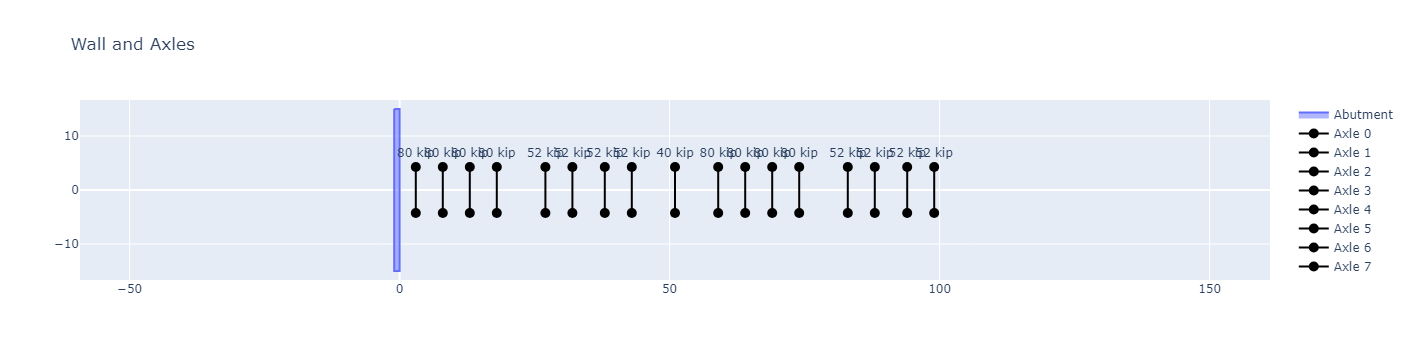

In [5]:
# Draw abutment & axle loads


fig = go.Figure()

# Plot the abutment
def plot_abutment(fig):

    x, y = abutment['plotx'], abutment['ploty']    
    fig.add_trace(go.Scatter(x=x, y=y,
                             mode='lines',
                             name='Abutment',
                             fill='toself'))
plot_abutment(fig)

def plot_axle_concentrated(fig):
    # Plot the axle loads
    for iaxle, iloc in enumerate(LL['locations']):
        # Usually greatest effect moves the 1st axle behind the wall
        # Positive offset would move 1st axle away
        
        
        x = [iloc, iloc]
        y = [dist['tie_width']/2, -dist['tie_width']/2]
        magnitude = LL['magnitudes'][iaxle]

        fig.add_trace(go.Scatter(x=x, y=y,
                                mode='lines+markers+text',
                                name=f'Axle {iaxle}',
                                marker_color='rgba(0, 0, 0, 1.0)',
                                text=[f'{magnitude} kip',''],
                                textposition='top center',
                                marker_size=10))
plot_axle_concentrated(fig)

fig.update_layout(title=dict(text="Wall and Axles"))
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.show()

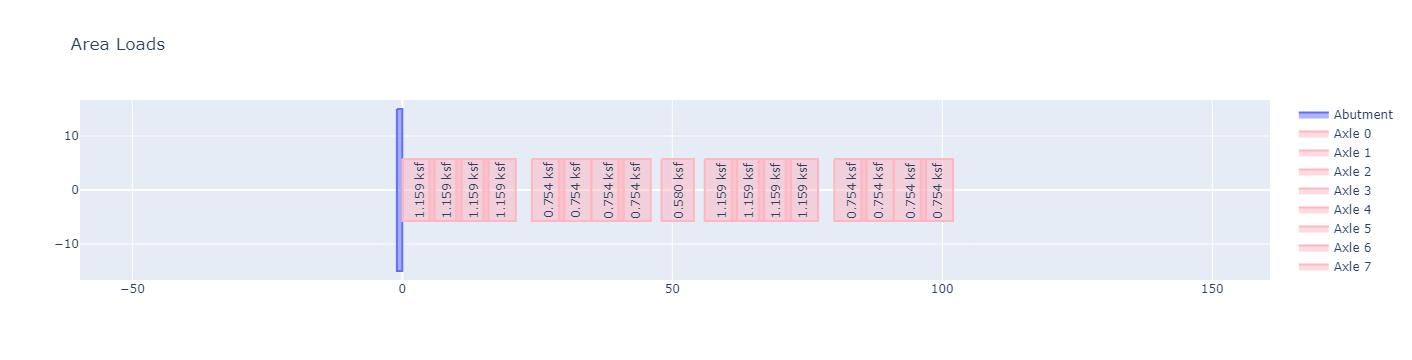

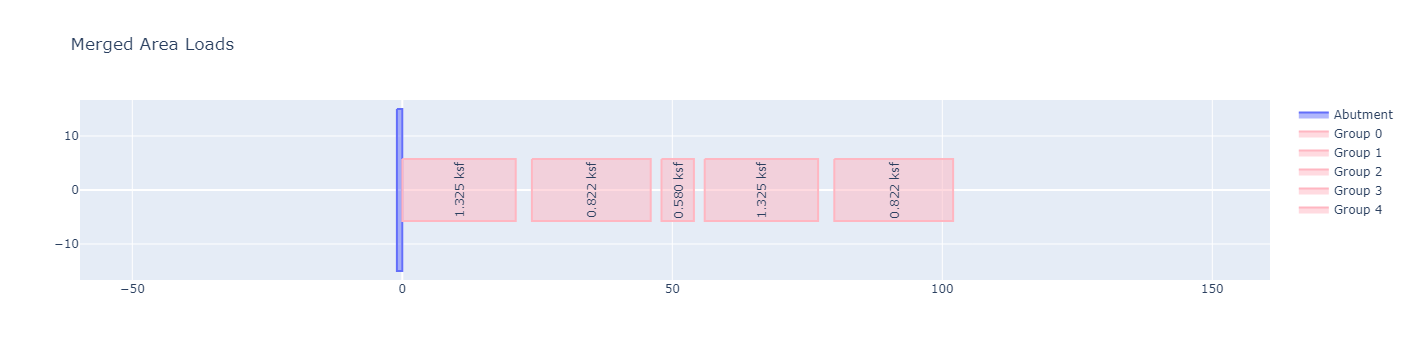

In [6]:
# Calculate distribution areas and pressures of live loading
area_loads = []

area_length = dist['length'] # ft, Distribution length
area_width = dist['width'] # ft, Distribution width

# Create dictionaries for each axle
for iaxle in range(LL['naxles']):
    loc = LL['distances'][iaxle] + LL['axle_offset']
    center = [loc, 0]
    
    x = [loc - area_length/2, loc + area_length/2, loc+area_length/2, loc-area_length/2, loc-area_length/2]
    y = [0+area_width/2, 0+area_width/2, 0-area_width/2, 0-area_width/2, 0+area_width/2]
    
    magnitude = LL['magnitudes'][iaxle] / (area_length * area_width)
    
    axle_dict = {'number': iaxle,
                'center': center,
                'x': x,
                'y': y,
                'magnitude': magnitude}
    area_loads.append(axle_dict)



# Plot these area loads:
def plot_area_load(fig, axle):
    # Plot a single axle rectangle
    x, y = axle['plotx'], axle['ploty']
    fig.add_trace(go.Scatter(x=x, y=y,
                             mode='lines',
                             name=axle["name"],
                             fill='toself',
                             line_color='lightpink'))
    x, y = axle['center'][0], axle['center'][1]
    mag = axle['magnitude']
    fig.add_annotation(x=x, y=y,
                       text=f'{mag:.3f} ksf',
                       showarrow=False,
                       textangle=-90,
                       yshift=0)
    # ax.text(axle['center'][0], axle['center'][1], 
    #        '{:.1f} ksf'.format(axle['magnitude']), 
    #         horizontalalignment='center',
    #         verticalalignment='center',
    #         fontsize=8,
    #        rotation=90)

def plot_area_loads(fig, area_loads):
    # Plot all axle rectangles
    for iarea in area_loads:
        plot_area_load(fig, iarea)


fig2 = go.Figure()
plot_abutment(fig2)
plot_area_loads(fig2, LL['area loads'])
fig2.update_layout(title=dict(text="Area Loads"))
fig2.update_yaxes(scaleanchor="x", scaleratio=1)
fig2.show()


fig3 = go.Figure()
plot_abutment(fig3)
plot_area_loads(fig3, LL['merged loads'])
fig3.update_layout(title=dict(text="Merged Area Loads"))
fig3.update_yaxes(scaleanchor="x", scaleratio=1)
fig3.show()

In [7]:
# Calculate distribution areas and pressures of live loading
area_loads = []

area_length = dist['length'] # ft, Distribution length
area_width = dist['width'] # ft, Distribution width

# Create dictionaries for each axle
for iaxle in range(LL['naxles']):
    loc = LL['distances'][iaxle] + LL['axle_offset']
    center = [loc, 0]
    
    x = [loc - area_length/2, loc + area_length/2, loc+area_length/2, loc-area_length/2, loc-area_length/2]
    y = [0+area_width/2, 0+area_width/2, 0-area_width/2, 0-area_width/2, 0+area_width/2]
    
    magnitude = LL['magnitudes'][iaxle] / (area_length * area_width)
    
    axle_dict = {'center': center,
                'x': x,
                'y': y,
                'magnitude': magnitude}
    area_loads.append(axle_dict)
    

def plot_area_load(ax, axle):
    # Plot a single axle rectangle
    ax.plot(axle['x'], axle['y'], color='red')
    ax.text(axle['center'][0], axle['center'][1], 
            '{:.1f} ksf'.format(axle['magnitude']), 
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=8,
           rotation=90)

def plot_area_loads(ax, area_loads):
    # Plot all axle rectangles
    for iarea in area_loads:
        plot_area_load(ax, iarea)

In [8]:
# Function which calculates effect of a load given:
# Load coordinates
# Load magnitude
# Wall Coordinates

#  TODO: Change the below function to take uniform inputs of:
#    loads, soil

def spangler(xLoad, yLoad, pLoad, xWall, zWall, **kwargs):
    
    # Make formulas similar to 
    h = abutment['height']
    a = yLoad/h
    b = zWall/h
    
    # print('a = {}'.format(a))
    # print('b = {}'.format(b))
    
    # Releative distance along the wall between load and wall location
    xrel = abs(xLoad - xWall)
    # print('xrel = {}'.format(xrel))
    
    # Angle of load to wall
    # print('yLoad = {}'.format(yLoad))
    alpha = math.atan2(xrel, yLoad)
    # print('alpha = {}'.format(alpha))
    
    if alpha > math.pi/2/1.1: 
        alpha = math.pi/2/1.1
    adjustment = math.cos(1.1*alpha)**2
    # print('adjustment = {}'.format(adjustment))
    
    
    
    if a > 0.4:
        phz =  (pLoad / (h**2)) * ((a**2 * b**2) / (a**2 + b**2)**3)
    else:
        phz = (0.28*pLoad / (h**2)) * ((b**2) / (0.16 + b**2)**3)
    
    return phz * adjustment * dist['R']



## Poulos & Davis Rectangular Surcharge Strip Perpendicular to Wall

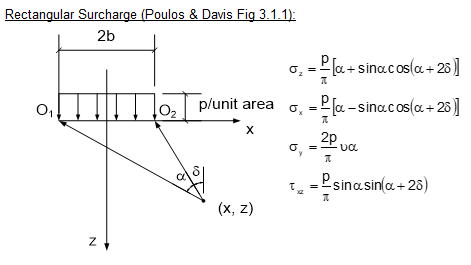


In [9]:
# 

def pdstrip(xwall, zwall, dist, abutment, LL):
    

    pressure = 0

    zuse = max(0.001, zwall)

    for imerged in LL['merged loads']:
        # print(f"left = {imerged['left']}, right = {imerged['right']}, pressure = {imerged['magnitude']}")

        if imerged['left'] >= 0:
            delta = math.atan2(imerged['left'], zuse)
        else:
            delta = 0
        
        if imerged['right'] >= 0:
            alpha = math.atan2(imerged['right'], zuse) - delta
        else:
            alpha = 0


        newpressure = imerged['magnitude'] / math.pi * (alpha - math.sin(alpha) * math.cos(alpha + 2*delta))
        pressure += newpressure
        # print(f'delta = {delta:.4f}, alpha = {alpha:.4f}, pressure = {newpressure:.4f}')

    return pressure * dist['R']

print(pdstrip(0, 1, dist, abutment, LL))

1.2783921029808305


In [10]:
# Rectangular super-position stress function

def rectangle_corner_stress(p, v, a, b, z, debug=False):
    # Calculate horizontal stress at the corner of
    # a rectangle
    
    # debug = True
    
    A = math.sqrt(a**2 + z**2)
    C = math.sqrt(a**2 + b**2 + z**2)
    
    if debug:
        print('a = {}'.format(a))
        print('b = {}'.format(b))
        print('z = {}'.format(z))
        print('A = {}'.format(A))
        print('C = {}'.format(C))
    
    
    # Deal with possible divide by 0 errors.
    # As z approaches 0, atan(ab/zC) approaches pi/2.
    # If z is 0, assume this term is pi/2
    if z == 0:
        t1 = math.pi/2
    else:
        t1 = math.atan(a*b/(z*C))
        
    if debug:
        print("t1 = {}".format(t1))
    
    
    # If a or b are 0, there is no area. Just return a 0
    if a == 0 or b == 0:
        if debug: print('Zero Area')
        return 0
    
    # Kim does not have the 2 on the bottom, but Poulos & Davis do
    # The missing 2 in Kim is because the rigidity factor has already been applied
    res = (p/(2*math.pi)) * (t1 + a*b*z/(A**2 * C) - (1-2*v)*(math.atan(b/a) - math.atan(z*b/(a*C)) - t1))
        
    if debug: print('stress = {}'.format(res))
    return res

def rectangle_stress(p, v, yWall, zWall, center, xlen, ylen, debug = False):
    # Calculate total stress on a point from a rectanglular load
    # Uses super-position of different rectanges
    # because equations are only for under a corner
    
    # four bounds of rectangle
    left = center[0] - xlen/2
    right = center[0] + xlen/2
    top = center[1] + ylen/2
    bottom = center[1] - ylen/2
    
    if debug:
        print('left = {}'.format(left))
        print('right = {}'.format(right))
        print('top = {}'.format(top))
        print('bottom = {}'.format(bottom))
    
    # Point being checked
    xp = 0
    yp = yWall
    zp = zWall
    
    EPS_wall = 1e-6 # Prevent roundoff errors from loads being on wall
    
    # Determine if the wall point lines up with
    # a corner, is within the top and bottom
    # or is above or below the load
    disTtoCorner = min(abs(top - yWall), abs(bottom - yWall))
    
    if disTtoCorner <= EPS_wall:
        edgecase = 'corner'
    elif top > yWall and bottom < yWall:
        edgecase = 'within'
    elif top < yWall:
        edgecase = 'above'
    else:
        edgecase = 'below'
        
    
    # Determine if load's left edge is
    # on, to the left or to the right of the wall
    
    if debug:
        print('abs(left) = {:.2E}'.format(abs(left)))
        print(abs(left) <= EPS_wall)
    if abs(left) <= EPS_wall:
        leftedge = 'on'
    elif left < 0:
        leftedge = 'left'
        if right < 0:
            # Load is behind wall on superstructure. Ignore
            return 0
    else:
        leftedge = 'right'
    
    # Cases:
    # Load edge on wall
    
    
    # rectangle_stress(p, v, a, b, z):
    
    # Cases 1-3: Left edge of rectangle on wall
    if leftedge == 'on':
        
        # 1. Wall under a coner
        if edgecase == 'corner':
            if debug: print('Case 1')
            return rectangle_corner_stress(p, v, right, top - bottom, zWall)
        
        # 2. Wall under an edge
        elif edgecase == 'within':
            if debug: print('Case 2')
            # Split load into 2 rectangles and add together
            
            # Rectangle from top of load to wall point
            if debug: print('top - yp = {}'.format(top-yp))
            R1 = rectangle_corner_stress(p, v, right, top - yp, zWall)
            
            # Rectangle from wall point to bottom of load
            if debug: print('yp - bottom = {}'.format(yp - bottom))
            R2 = rectangle_corner_stress(p, v, right, yp - bottom, zWall)
            
            return R1 + R2
        
        # 3. Wall outside of load
        else:
            if debug: print('Case 3')
            # Subtract un-loaded rectangle from (load + un-load) rectangle
            if edgecase == 'above':
                btot = yWall - bottom
                brem = yWall - top
                
                if debug:
                    print('above')
            else:
                btot = top - yWall
                brem = bottom - yWall
                
                if debug:
                    print('below')
            
            if debug:
                print('btot = {}'.format(btot))
                print('brem = {}'.format(brem))
            
            # Rectangle drawn around both load and wall point.
            Rtot = rectangle_corner_stress(p, v, right, btot, zWall)
            
            # Rectangle of un-loaded area from wall poitn to edge of wall
            Rrem = rectangle_corner_stress(p, v, right, brem, zWall)
            
            return Rtot - Rrem
    
    # 4-6 Load edge to the right of wall
    elif leftedge == 'right':
        atot = right
        arem = left
        
        # 4. Wall under a coner
        if edgecase == 'corner':
            if debug: print('Case 4')
            Rtot = rectangle_corner_stress(p, v, atot, top - bottom, zWall)
            Rrem = rectangle_corner_stress(p, v, arem, top - bottom, zWall)
            
            return Rtot - Rrem
        
        # 5. Wall under an edge
        elif edgecase == 'within':
            if debug: print('Case 5')
            # Split load into 4 rectangles
            
            # Rectangle from top of load to wall point
            R1 = rectangle_corner_stress(p, v, atot, top - yp, zWall, debug)
            
            # Rectangle from wall point to bottom of load
            R2 = rectangle_corner_stress(p, v, arem, top - yp, zWall, debug)
            
            # Rectangle from top of load to wall point
            R3 = rectangle_corner_stress(p, v, atot, yp - bottom, zWall, debug)
            
            # Rectangle from wall point to bottom of load
            R4 = rectangle_corner_stress(p, v, arem, yp - bottom, zWall, debug)
            
            return R1 - R2 + R3 - R4
        
        # 6. Wall outside of load
        else:
            if debug: print('Case 6')
            # Subtract un-loaded rectangle from (load + un-load) rectangle
            if edgecase == 'above':
                btot = yWall - bottom
                brem = yWall - top
            else:
                btot = top - yWall
                brem = bottom - yWall
            
            # Rectangle from top of load to wall point
            R1 = rectangle_corner_stress(p, v, atot, btot, zWall)
            
            # Rectangle from wall point to bottom of load
            R2 = rectangle_corner_stress(p, v, arem, btot, zWall)
            
            # Rectangle from top of load to wall point
            R3 = rectangle_corner_stress(p, v, atot, brem, zWall)
            
            # Rectangle from wall point to bottom of load
            R4 = rectangle_corner_stress(p, v, arem, brem, zWall)
            
            return R1 - R2 - R3 + R4
            
            return Rtot - Rrem
     
    
    # 7-9 Load straddles wall  
    else:
        # Clip part of load behind wall to put in case 1-3 and return that value
        
        if debug:
            if edgecase == 'corner':
                print('Case 7')
            elif edgecase == 'within':
                print('Case 8')
            else:
                print('Case 9')
        
        newxlen = right
        newcenter = [right/2, center[1]]
        return stress(p, v, yWall, zWall, newcenter, newxlen, ylen, debug)
        




def pdarea(xwall, zwall, dist, abutment, LL):

    

    v = dist['v'] # Poisson's ratio
    
    # Location on wall. Uses reference coordinates
    yWall = xwall
    zWall = zwall
    debug = False
    
    pressure = 0


    for imerged in LL['merged loads']:

        p = imerged['magnitude']

        
        center = imerged['center']
        xlen = imerged['length']
        ylen = imerged['width']

        newpressure = rectangle_stress(p, v, yWall, zWall, center, xlen, ylen, debug)
        pressure += newpressure

    return pressure * dist['R']

"""
p = 2.1052631578947367
v = 0.3
yWall = 4.599198396793586
zWall = 0.033444816053511704
center = [6.5, 0]
xlen = 4
ylen = 9.5
print(rectangle_stress(p, v, yWall, zWall, center, xlen, ylen, debug=True))"""

'\np = 2.1052631578947367\nv = 0.3\nyWall = 4.599198396793586\nzWall = 0.033444816053511704\ncenter = [6.5, 0]\nxlen = 4\nylen = 9.5\nprint(rectangle_stress(p, v, yWall, zWall, center, xlen, ylen, debug=True))'

# 

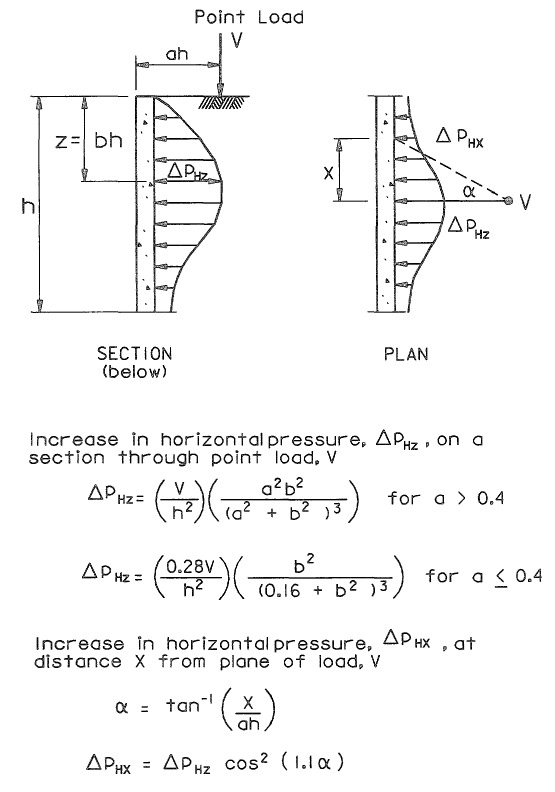

In [11]:
# Boussinesq point load
def bpoint(xLoad, yLoad, zLoad, pLoad, yWall, zWall, v):

    x = xLoad
    y = abs(yLoad - yWall)
    z = zLoad - zWall
    R = math.sqrt(x**2 + y**2 + z**2)


    return pLoad / (2 * math.pi) * (3*z*(x**2)/(R**5) - (1 - 2*v)*(z/(R**3) - 1/(R*(R+z)) + (2*R+z)*(x**2) / ((R**3) * ((R + z)**2))))



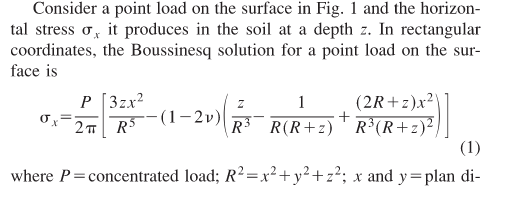

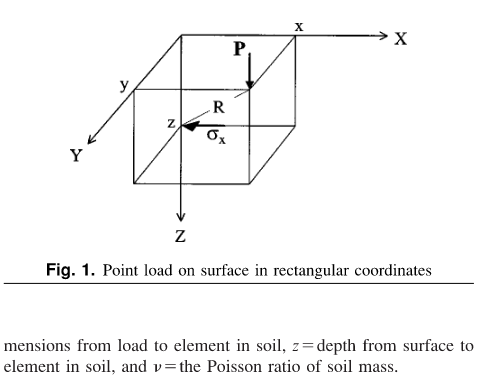

In [12]:
# Split wall up into squares.
# Pressure will be calculated at corner of each square.


nrows = 30
ncols = 50



x = np.linspace(-abutment['length']/2, abutment['length']/2, num = ncols)
y = np.linspace(0, abutment['height'], num = nrows)
# print('x = {}'.format(x))
# print('y = {}'.format(y))


Z = np.zeros(nrows * ncols).reshape(nrows, ncols)


# Plot effect from one axle centered
# surcharge(xLoad, yLoad, pLoad, xWall, zWall)
xLoad = 0
yLoad = 1 # ft, Distance from wall
pLoad = 80 # Kip

old_perc = -1


for i in range(nrows):
    for j in range(ncols):
        for iaxle in range(len(area_loads)):
            
            xt, yt = x[j], y[i]

            xLoad = -dist['tie_width']/2
            yLoad = area_loads[iaxle]['center'][0]
            pLoad = LL['magnitudes'][iaxle]/2
            Z[i][j] += spangler(xLoad, yLoad, pLoad, x[j], y[i])
            
            xLoad = dist['tie_width']/2
            Z[i][j] += spangler(xLoad, yLoad, pLoad, x[j], y[i])
    
    
    percent_complete = round((i+1) / nrows * 100,-1)
    
    if percent_complete != old_perc:
        print('{}% complete'.format(percent_complete))
        old_perc = percent_complete

# print(Z)




0.0% complete
10.0% complete
20.0% complete
30.0% complete
40.0% complete
50.0% complete
60.0% complete
70.0% complete
80.0% complete
90.0% complete
100.0% complete


In [13]:
def get_pressure(x, y, nrows, ncols, surcharge, abutment, LL, dist):
    """Generic pressure calculation. Includes a specific
    surcharge function as an input

    Args:
        x ([float]): X coordinates on grid on the abutment
        y ([float]): Y coordinates on grid on the abutment
        nrows (int): _description_
        ncols (int): _description_
        surcharge (function): Surcharge function which takes x, z coordinates and
            dist, abutment, LL
        abutment (dict): Dictionary describing abutment
        LL (dict): Dictionary describing live load
        dist (dict): Dictionary describing distribution

    Returns:
        [float]: nxn Array with pressure values on x & y grid
    """
    Z = np.zeros(nrows * ncols).reshape(nrows, ncols)

    old_perc = -1
    for i in range(nrows):
        for j in range(ncols):
                
            # print(f'i = {i}, j = {j}')
            Z[i][j] += surcharge(x[j], y[i], dist, abutment, LL)
                
                
    
        percent_complete = round((i+1) / nrows * 100,-1)
    
        if percent_complete != old_perc:
            print(f'{percent_complete}% complete')
            old_perc = percent_complete
    
    return Z

print("Strip method:")
Zstrip = get_pressure(x, y, nrows, ncols, pdstrip, abutment, LL, dist)
print("Area method:")
Zrect = get_pressure(x, y, nrows, ncols, pdarea, abutment, LL, dist)

Strip method:
0.0% complete
10.0% complete
20.0% complete
30.0% complete
40.0% complete
50.0% complete
60.0% complete
70.0% complete
80.0% complete
90.0% complete
100.0% complete
Area method:
0.0% complete
10.0% complete
20.0% complete
30.0% complete
40.0% complete
50.0% complete
60.0% complete
70.0% complete
80.0% complete
90.0% complete
100.0% complete


In [14]:



def add_surface(fig, x, y, z, name='None', color = 'None'):
    # this all gets repeated below:

    if color == 'None':
        fig.add_trace(go.Surface(x=x, y=y, z=z, colorscale='Turbo', opacity=0.5))
    else:
        
        fig.add_trace(go.Surface(x=x, y=y, z=z, colorscale=[color, color], opacity=0.5))
    


fig3D = go.Figure()
add_surface(fig3D, x, -y, Z, color='red')
add_surface(fig3D, x, -y, Zstrip, color='green')
add_surface(fig3D, x, -y, Zrect, color='blue')


distance = 0.75*Z.max()
camera = dict(
    up=dict(x=0, y=1, z=0),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=distance, y=distance, z=distance))



fig3D.update_layout(title=dict(text="Axle Area Loads"),
                    width=800, height=800,
                    scene=dict(camera=camera))


fig3D.update_yaxes(autorange='reversed')
fig3D.show()

# print(abutment['height'])
print('Max Pressure = {:.2f} ksf'.format(Z.max()))

Max Pressure = 1.56 ksf


In [15]:
'''print(f'x = {x}')
print(f'y = {y}')
print(f'len(x) = {len(x)}')
print(f'len(y) = {len(y)}')'''

def add_grid(fig, x, y, z, color='blue'):
    # this all gets repeated below:

    # Plot lines with constant X axis values
    for i, ix in enumerate(x):


        plotx = [ix] * len(y)
        ploty = [None] * len(y)
        plotz = [None] * len(y)
        
        for j, jy in enumerate(y):
            # print(f'i = {i}, j = {j}')

            ploty[j] = -y[j]
            plotz[j] = z[j][i]

        fig.add_scatter3d(x=plotx, y=ploty, z=plotz, 
                        mode='lines', 
                        line=dict(
                            color=color
                        ))
        
    # Plot lines with constant Y axis value    
    for j, jy in enumerate(y):


        plotx = [None] * len(x)
        ploty = [-jy] * len(x)
        plotz = [None] * len(x)
        
        for i, ix in enumerate(x):
            # print(f'i = {i}, j = {j}')

            plotx[i] = x[i]
            plotz[i] = z[j][i]

        fig.add_scatter3d(x=plotx, y=ploty, z=plotz, 
                        mode='lines', 
                        line=dict(
                            color=color
                        ))

                
figGrid = go.Figure()
add_grid(figGrid, x, y, Z, 'red')
add_grid(figGrid, x, y, Zstrip, 'green')
add_grid(figGrid, x, y, Zrect, 'blue')


distance = 0.6*Z.max()
camera = dict(
    up=dict(x=0, y=1, z=0),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=distance, y=distance, z=distance))



figGrid.update_layout(title=dict(text="Axle Area Loads"),
                    width=800, height=800,
                    scene=dict(camera=camera),
                    showlegend=False)


figGrid.update_yaxes(autorange='reversed')
figGrid.show()